# CLEAN BUILD FROM SCRATCH EFFNET-UNET b7 on patches

In [1]:
CURRENT_FOLD = 3

# imports

In [2]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torch.cuda.amp as amp
is_amp = True

# data

In [3]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

# model testing

In [4]:
from model import Net
from mit import mit_b2

In [5]:
mixtr = Net()

In [6]:
sample_input = torch.randn(1, 3, 512, 512)

In [7]:
sample_mask = torch.tensor([[0, 1], [1, 0]]).repeat(8, 8)

In [8]:
sample_mask.shape

torch.Size([16, 16])

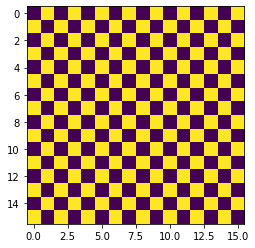

In [9]:
plt.imshow(sample_mask)
plt.show()

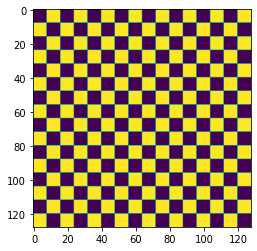

In [10]:
plt.imshow(F.interpolate(sample_mask.unsqueeze(0).unsqueeze(1).to(dtype=torch.float32), size=(128, 128))[0][0])
plt.show()

In [11]:
sample_mask = sample_mask.unsqueeze(0).unsqueeze(1)

In [12]:
sample_output = mixtr.forward_mae({'image': sample_input, 
                                           'mae_mask': sample_mask.to(dtype=torch.float32)})

In [13]:
sample_output['mae_logit'].shape

torch.Size([1, 3, 256, 256])

## data 512

In [14]:
# img256 = cv.imread('./../data/train_data_eunet_patches/256/train/10044_0000.png')
# img512 = cv.imread('./../data/train_data_eunet_patches/512/train/10044_0000.png')

In [15]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_data_eunet_patches/512/train/'
TRAIN_MASKS_DIR = './../data/train_data_eunet_patches/512/masks/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022

SPATIAL_SIZE = 512 # размер патча


In [16]:
train_df = pd.read_csv(TRAIN_CSV)

In [17]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [18]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [19]:
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,4.0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,0.0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,0.0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0.0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,4.0


In [20]:
def make_512_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}_*.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('/train/', '/masks/')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [21]:
train_df_512 = make_512_dataset(train_df)
print(train_df_512.shape)
train_df_512.head()

(2895, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
1,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
2,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
3,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
4,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4


In [22]:
# ---------------------------------------------------------------
# WARNING! THIS RESCALE IS INJECTED IN SWIN TRANSFORMER ALREADY!
#   RGB LAYER
# IT'S INPUTS HAVE TO BE IMAGE IN 0..1!
# ---------------------------------------------------------------

In [23]:
# mean = np.array([0.7720342, 0.74582646, 0.76392896])
# std = np.array([0.24745085, 0.26182273, 0.25782376])

In [24]:
train_transform= A.Compose([
    A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
#     A.HueSaturationValue(p=0.25),
#     A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(0.05, 0.6),rotate_limit=90, p=0.5),
#     A.ElasticTransform(p=0.05, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
#     A.GridDistortion(p=0.25),
    A.Blur(blur_limit=5, p=0.1),
    A.GaussNoise(var_limit=(20, 100), p=0.2),
#     A.ChannelDropout(p=0.05),
    A.RandomGamma(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [25]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [26]:
def gen_random_mask(shape, ratio=0.6):
    mask = np.ones(shape[0] * shape[1], dtype=np.float32)
    N = len(mask)
    mask[:int(N * ratio)] = 0.0
    np.random.shuffle(mask)
    mask = mask.reshape(shape[0], shape[1])
    return mask

In [27]:
mask = gen_random_mask((16, 16))

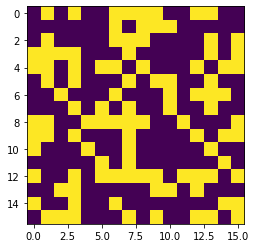

In [28]:
plt.imshow(mask)
plt.show()

In [29]:
class HubmapMitPretrainDataset512(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        mae_mask = gen_random_mask((16, 16), ratio=0.3)
        mae_mask = cv.resize(mae_mask, dsize=(image.shape[0]//4, image.shape[1]//4), interpolation=cv.INTER_NEAREST)
        mae_mask = torch.tensor(mae_mask)

        data = {
            'image': image,
            'mae_mask': mae_mask
        }
        upd_data = self.transform(image=data['image'])

        data.update(upd_data)
        return data

In [30]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [31]:
train_dataset = HubmapMitPretrainDataset512(train_df_512[train_df_512['fold'] != CURRENT_FOLD], train_transform)
val_dataset = HubmapMitPretrainDataset512(train_df_512[train_df_512['fold'] == CURRENT_FOLD], val_transform)

IMAGE
torch.Size([3, 512, 512])
image values:  0.0 1.0


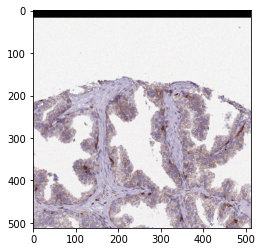

MASK
torch.Size([128, 128])
mask values:  tensor(0.) tensor(1.)


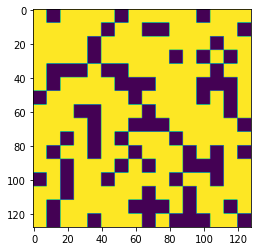

In [32]:
sample = train_dataset[1]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mae_mask'].shape)
print('mask values: ', sample['mae_mask'].min(), sample['mae_mask'].max())
plt.imshow(sample['mae_mask'])
plt.show()

In [33]:
BATCH_SIZE = 10

In [34]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          worker_init_fn=worker_init_fn,
                          num_workers=12
                         )
loader_val = DataLoader(val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        worker_init_fn=worker_init_fn,
                        num_workers=0
                       )

IMAGE
torch.Size([3, 512, 512])
image values:  0.0 1.0


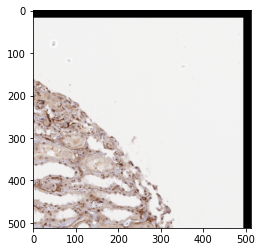

MASK
torch.Size([128, 128])
mask values:  tensor(0.) tensor(1.)


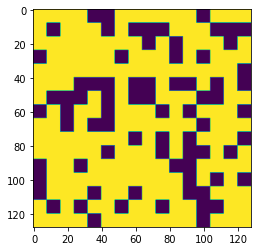

In [35]:
sample = val_dataset[2]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mae_mask'].shape)
print('mask values: ', sample['mae_mask'].min(), sample['mae_mask'].max())
plt.imshow(sample['mae_mask'])
plt.show()

# model

In [36]:
device = 'cuda:2'
DEVICE = device

In [37]:
pretrain_dir = './../mit-b2-segformer-first-try/'

In [38]:
model = Net().to(device)

In [39]:
model.load_pretrain()

load ./../mit-b2-segformer-first-try//mit_b2.pth
_IncompatibleKeys(missing_keys=['mask_token'], unexpected_keys=['head.weight', 'head.bias'])


In [40]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

28937587

# lr schedule

In [41]:
def lr_function(step):
    start_lr = 1e-5; min_lr = 1e-5; max_lr = 5e-4    #A
    rampup_epochs = 1000; sustain_epochs = 200; exp_decay = 1    #B
 
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs,
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:    #C
            lr = ((max_lr - start_lr) / rampup_epochs
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:    #D
            lr = max_lr
        else:    #E
            lr = max((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs)* (0.8+0.01*np.sin(epoch / 100)), 0) + min_lr
        return lr
 
    return lr(step, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay) / max_lr

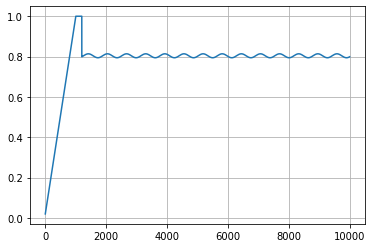

In [42]:
xxx = []
for i in range(10000):
    xxx.append(lr_function(i))
    
plt.plot(xxx)
plt.grid()
plt.show()

# Criterions

In [43]:
import segmentation_models_pytorch as smp

In [44]:
# def criterion_aux_loss(logit, mask):
#     mask = F.interpolate(mask,size=logit.shape[-2:], mode='nearest')
#     print(logit.shape, mask.shape)
#     loss = F.cross_entropy(logit, mask)
#     return loss

In [45]:
l1loss = nn.L1Loss()
l2loss = nn.MSELoss()
def criterion(pred, true):
    return  0.9 * l1loss(pred, true) + 0.1 * l2loss(pred, true)

# validation code

In [46]:
import monai
from monai.utils.enums import BlendMode, PytorchPadMode
from monai.inferers import sliding_window_inference

In [47]:
class Predictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        _, _, H, W = x.shape
        H = int(H)
        W = int(W)
        
        mae_mask = gen_random_mask((16, 16), ratio=0.6)
        mae_mask = cv.resize(mae_mask, dsize=(H//4, W//4), interpolation=cv.INTER_NEAREST)
        mae_mask = torch.tensor(mae_mask).unsqueeze(0).unsqueeze(1).to(device)
        
        
        out = self.model.forward_mae({'image' : x, 'mae_mask': mae_mask})
#         print(out.keys())
        img = F.interpolate(out['mae_logit'], size=(512, 512))
        return img

In [48]:
def infer_id(predictor, id: str, organ: str, pixel_size=0.4):
    
    image = cv.imread('./../data/train_images/{}.tiff'.format(id))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    scale_factor = 0.5 * (pixel_size / 0.4)
    image = cv.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)
    
    masks = []
        
    image_tensor = val_transform(image=image)['image']

    image_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        infer_result = sliding_window_inference(
            image_tensor, roi_size=(512, 512), sw_batch_size=2, predictor=predictor, 
            overlap=0.5, mode=BlendMode.CONSTANT, sigma_scale=0.125, 
            padding_mode=PytorchPadMode.CONSTANT, cval=0.0,       
        )

    
    pr_img = infer_result.detach().cpu().numpy()[0].transpose((1, 2, 0)).astype(np.float32)
    
#     print(pr_img.shape)
        
    pr_img = cv.resize(pr_img, dsize=image.shape[:2], interpolation=cv.INTER_NEAREST)
    
    return pr_img, image.astype(np.float32) / 255.0

In [49]:
def validate(val_df, model):
    predictor = Predictor(model)
    
    mae_losses = []
    
    by_organ_mae_losses = {key:[] for key in ORGAN2ID.keys()}
    for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
        id = row['id']
        organ = row['organ']
        pixel_size = row['pixel_size']
        pred_img, gt_img = infer_id(predictor, id, organ=organ, pixel_size=pixel_size)
        mae_loss = np.abs(pred_img - gt_img).mean()
        mae_losses.append(mae_loss)
        by_organ_mae_losses[organ].append(mae_loss)
    new_record = dict()
    new_record['dices'] = mae_losses
    new_record['by_organ'] = by_organ_mae_losses
    return new_record

In [50]:
val_df_id = train_df[train_df['fold'] == CURRENT_FOLD]

# training

In [51]:
learning_rate = 4e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)

In [52]:
scaler = amp.GradScaler(enabled = is_amp)

In [53]:
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_function)

In [54]:
train_loss = []
accuracy = [] 
lr_hist = []

In [55]:
PTH = './checkpoint_pretrain_fold_{}'.format(CURRENT_FOLD)

In [56]:
Path(PTH).mkdir(parents=True, exist_ok=True)

In [57]:
logfile = open(PTH + '/log.train.txt', mode='a')
logfile.write('\n--- [START %s] %s\n\n' % ('mitb2 pretrain', '-' * 64))

94

In [58]:
def log(string):
    print(string)
    logfile.write(string + '\n')

In [59]:
N_EPOCHS = 450
global_it = 0
VIRTUAL_BATCH_SIZE = 2

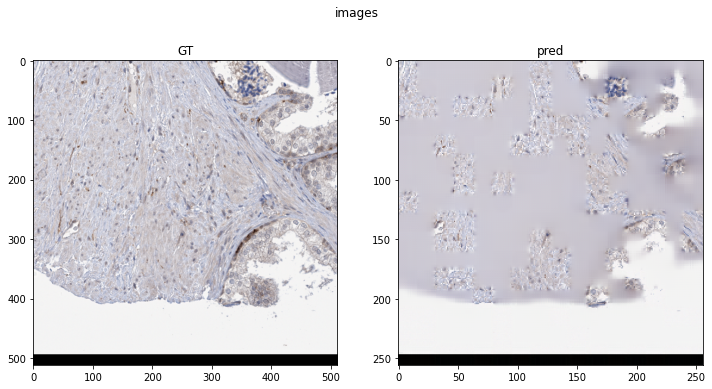

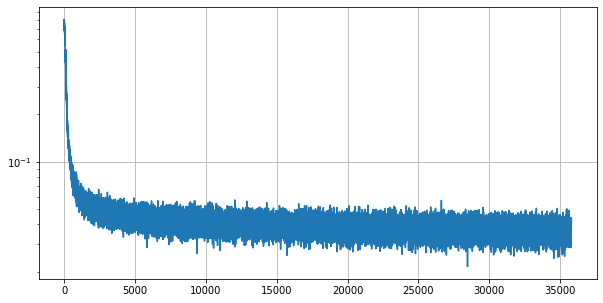

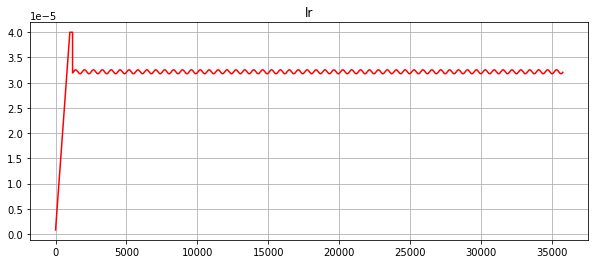

==> Epoch 309 (210/231) | loss: 0.03886


In [ ]:
for epoch in range(N_EPOCHS):
    criterion_image = criterion
    
    model.train()
    
    batch_train_loss = []
    
    for iteration, batch in enumerate(loader_train):
        global_it += 1
#         print(batch['mae_mask'].shape)
        batch['image'] = batch['image'].half().to(device)
        batch['mae_mask'] = batch['mae_mask'].unsqueeze(1).to(device, dtype=torch.float32)

        
        
        with amp.autocast(enabled = is_amp):
            output = model.forward_mae(batch)
            pred_image = output['mae_logit']
            
            inter_image = F.interpolate(batch['image'], size=pred_image.shape[2:4])
            loss = criterion_image(pred_image, inter_image)
            

        optimizer.zero_grad()
#         loss = loss0 + 0.4 * loss_aux0 + 0.1 * loss_aux1 + 0.005 * loss_aux2
        
        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()

        
        # ---
                 
        batch_train_loss.append(loss.item())          
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            train_loss.append(np.mean(batch_train_loss))
            batch_train_loss = []
            lr_hist.append(optimizer.param_groups[0]['lr'])
            scheduler_warmup.step()
                    
        if global_it % (VIRTUAL_BATCH_SIZE * 5) == 0:
            log('==> Epoch {} ({:03d}/{:03d}) | loss: {:.5f}'.format(epoch, iteration, len(loader_train), loss.item()))


        if iteration % (VIRTUAL_BATCH_SIZE * 100) == 0:
            clear_output()
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            fig.suptitle('images')
            ax1.imshow(batch['image'][0].detach().cpu().numpy().transpose((1, 2, 0)).astype(np.float32))
            ax1.set_title('GT')
            ax2.imshow(np.clip(pred_image[0].detach().cpu().numpy().transpose((1, 2, 0)), 0.0, 1.0).astype(np.float32))
            ax2.set_title('pred')
            
            plt.figure(figsize=(10, 5))
            plt.yscale('log')
            plt.plot(train_loss)
            plt.grid()
            plt.show()
              
            plt.figure(figsize=(10, 4))
            plt.plot(lr_hist, color='red')
            plt.title('lr')
            plt.grid()
            plt.show()
               
    # val -------------------------------
    if epoch % 10 == 0:
        log('Eval')
        model.eval()

        with torch.no_grad():
            val_res = validate(val_df_id, model)
            val_dice = np.mean(val_res['dices'])
            log('DICE: {}'.format(val_dice))
            for key, value in val_res['by_organ'].items():
                log('{:20}: {:6.5f}'.format(key, np.mean(value)))

            torch.save(model.state_dict(), os.path.join(
                PTH, 
                'mit-b2_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
            )) 

            logfile.flush()
    